# Feature Manipulation in Pandas

Here let's look at a different dataset that will allow us to really dive into some meaningful visualizations. This data set is publically available, but it is also part of a Kaggle competition.

You can get the data from here: https://www.kaggle.com/c/titanic-gettingStarted or you can use the code below to load the data from GitHub.

There are lots of iPython notebooks for looking at the Titanic data. Check them out and see if you like any better than this one!

When going through visualization options, I recommend the following steps:
- Would you like the visual to be interactive?
  - Yes, Does it have a lot of data?
    - No, Use plotly or bokeh
    - Yes, sub-sample and then use plotly/bokeh
    - Yes, think about using Turi for large data
  - No, Does seaborn have a built-in function for plotting?
    - Yes, use seaborn
    - No, Does Pandas support the visual?
      - Yes, use pandas
      - No, use low level matplotlib
      
Look at various high level plotting libraries like:
- Altair (https://altair-viz.github.io)
- Bokeh (http://bokeh.pydata.org/en/latest/)
- And many others...

## Adding Dependencies (for Jupyter Lab)
- `conda install -c conda-forge missingno`
- `conda install nodejs`
- `jupyter labextension install @jupyterlab/plotly-extension`

# Loading the Titanic Data for Example Visualizations

In [1]:
# load the Titanic dataset
import pandas as pd
import numpy as np

print('Pandas:', pd.__version__)
print('Numpy:',np.__version__)

df = pd.read_csv('https://raw.githubusercontent.com/eclarson/DataMiningNotebooks/master/data/titanic.csv') # read in the csv file

df.head()

Pandas: 1.2.1
Numpy: 1.19.2


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# note that the describe function defaults to using only some variables
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
print(df.dtypes)
print('===========')
print(df.info())

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2

## Questions we might want to ask:
- What percentage of passengers survived the Titanic disaster?
- What percentage survived in each class (first, coach, etc.)?
- How many people traveled in each class? How many classes are there?



In [4]:
# the percentage of individuals that survived on the titanic
sum(df.Survived==1)/len(df)*100.0

38.38383838383838

## Grouping the Data

In [5]:
# Lets aggregate by class and count survival rates
df_grouped = df.groupby(by='Pclass')
for val,grp in df_grouped:
    print('There were',len(grp),'people traveling in',val,'class.')

There were 216 people traveling in 1 class.
There were 184 people traveling in 2 class.
There were 491 people traveling in 3 class.


In [6]:
# an example of using the groupby function with a data column
print(df_grouped['Survived'].sum())
print('---------------------------------------')
print(df_grouped.Survived.count())
print('---------------------------------------')
print(df_grouped.Survived.sum() / df_grouped.Survived.count())

# might there be a better way of displaying this data?

Pclass
1    136
2     87
3    119
Name: Survived, dtype: int64
---------------------------------------
Pclass
1    216
2    184
3    491
Name: Survived, dtype: int64
---------------------------------------
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


Class Exercise 📝: 

In [9]:
# Class Exercise: Create code for calculating the std error
# std / sqrt(N) 
df_grouped.Survived.std() / np.sqrt(df_grouped.Survived.count())

Pclass
1    0.032934
2    0.036906
3    0.019358
Name: Survived, dtype: float64

___________
# Cleaning the Dataset
Let's start by visualizing some of the missing data in this dataset. We will use the `missingno` package to help visualize where the data contains `NaNs`. This is a great tool for looking at nan values and how we might go about filling in the values. 

For this visualization, we can use a visualization library called `missingno` that hs many types of visuals for looking at missing data in a dataframe. I particularly like the `matrix` visualization, but there are many more to explore:
- https://github.com/ResidentMario/missingno

### Plot Type One: Filter Bar

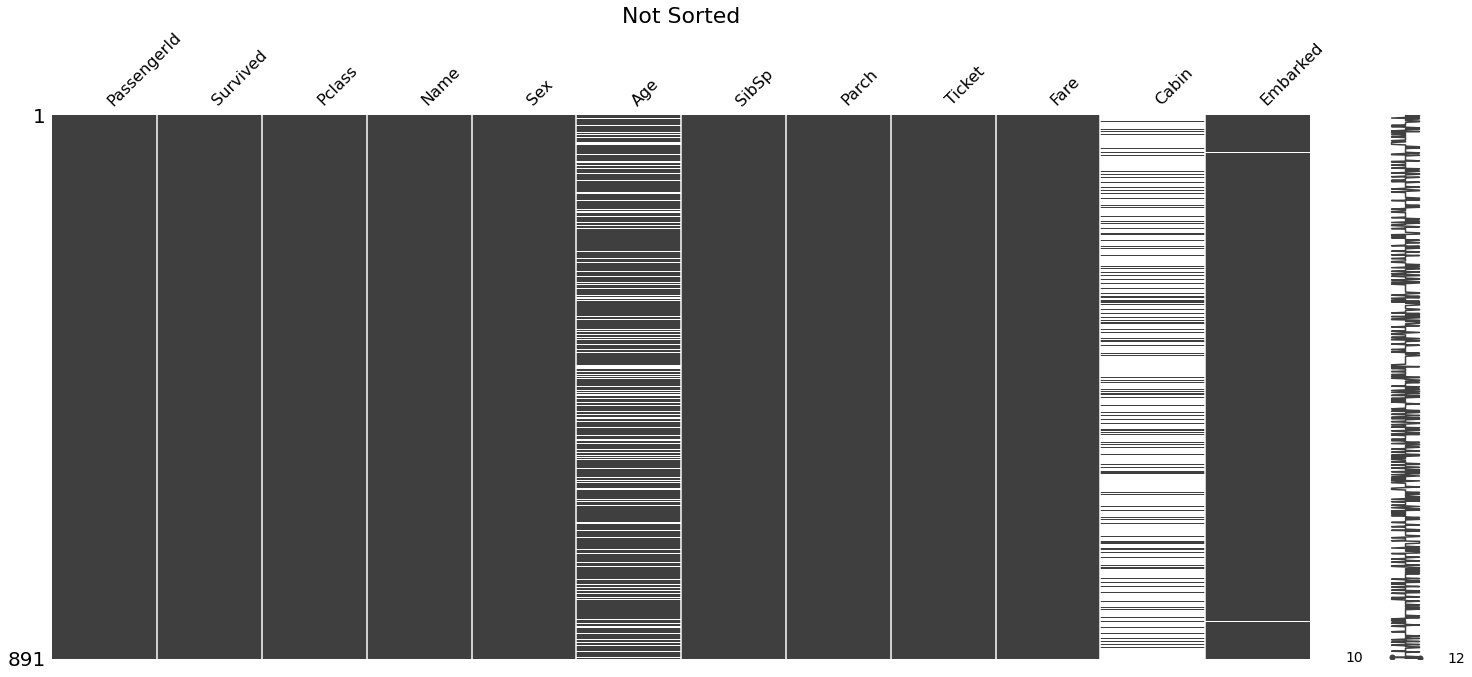

<Figure size 432x288 with 0 Axes>

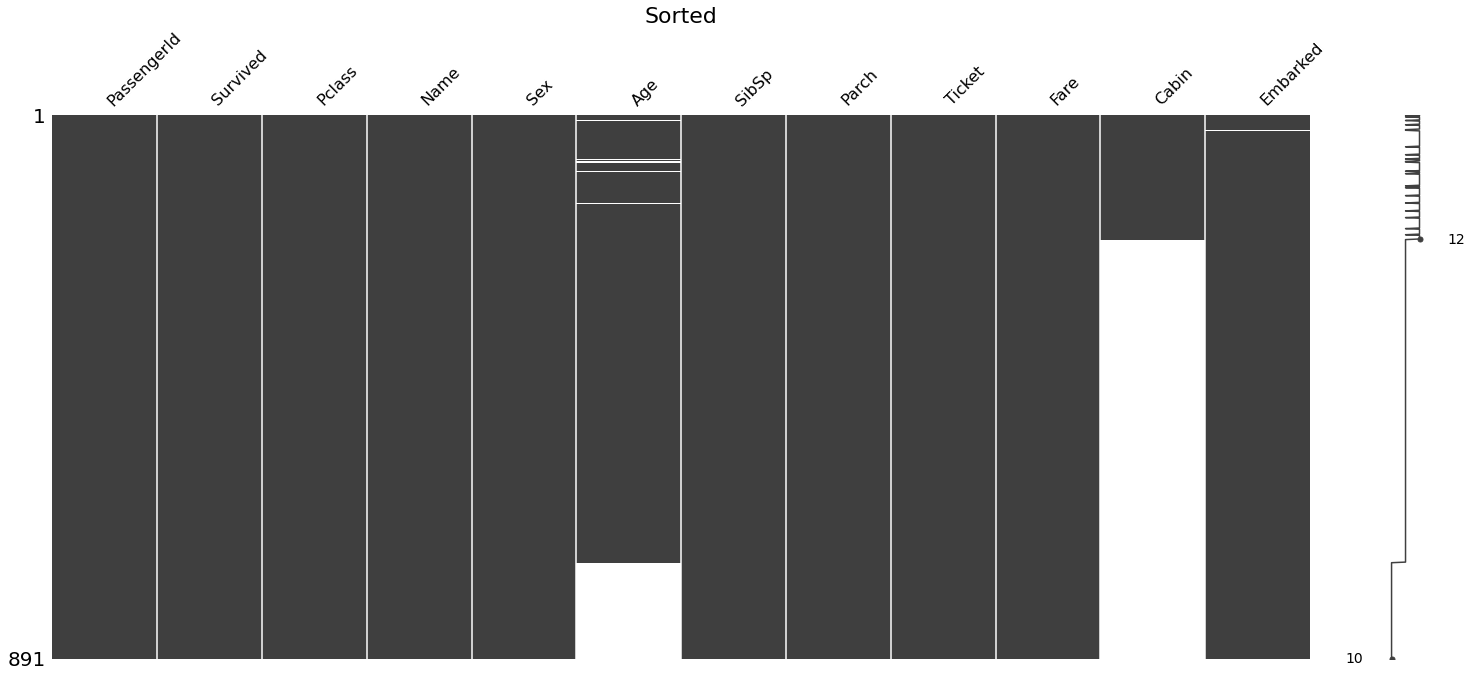

In [11]:
# this python magics will allow plot to be embedded into the notebook
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

import missingno as mn

mn.matrix(df)
plt.title("Not Sorted",fontsize=22)

plt.figure()
mn.matrix(df.sort_values(by=["Cabin","Age",]))
plt.title("Sorted",fontsize=22)
plt.show()

In [12]:
# let's clean the dataset a little before moving on

# 1. Remove attributes that just arent useful for us
for col in ['PassengerId','Name','Cabin','Ticket']:
    if col in df:
        del df[col]
        
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


## Imputation Techniques 
Let's compare two different techniques from lecture on how to fill in missing data. Recall that imputation should be done with a great deal of caution. Here, the Age variable seems to be missing about 15% of the values. That might be too many to impute. Let's try two methods of imputation on the Age variable: 
- Split-Imput-Combine
- Nearest Neighbor Imputation 

### Split-Impute-Combine in Pandas

In [13]:
# This code is for split, impute, combine
#     let's clean the dataset a little before moving on


# Impute some missing values, grouped by their Pclass and SibSp numbers, 
# then use this grouping to fill the data set in each group, then transform back


df_grouped = df.groupby(by=['Survived','Pclass','SibSp','Parch']) # perform the grouping of thing related to 'age'
func = lambda grp: grp.fillna(grp.mean()) # within groups, fill using median (define function to do this)
df_imputed_sac = df_grouped.transform(func) # apply impute and transform the data back

# Extra step: fill any deleted columns from the operation
col_deleted = list( set(df.columns) - set(df_imputed_sac.columns)) # in case the median operation deleted columns
df_imputed_sac[col_deleted] = df[col_deleted]

# drop any rows that still had missing values after grouped imputation
df_imputed_sac.dropna(inplace=True)

# 5. Rearrange the columns
df_imputed_sac = df_imputed_sac[['Survived','Age','Sex','Parch','SibSp','Pclass','Fare','Embarked']]
df_imputed_sac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 880 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  880 non-null    int64  
 1   Age       880 non-null    float64
 2   Sex       880 non-null    object 
 3   Parch     880 non-null    int64  
 4   SibSp     880 non-null    int64  
 5   Pclass    880 non-null    int64  
 6   Fare      880 non-null    float64
 7   Embarked  880 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 61.9+ KB


### Nearest Neighbor Imputation with Scikit-learn
Now let's try to fill in the Age variable by selecting the 3 nearest data points to the given observation. Here, we can use additional variables in the distance calculation, as compared to the need for discrete variable in the split-impute-combine method. 

In [16]:
# impute based upon the K closest samples (rows)
# our first introduction to sklearn!!!
from sklearn.impute import KNNImputer
import copy

# get object for imputation
knn_obj = KNNImputer(n_neighbors=3)

features_to_use = ['Pclass','Age','SibSp','Parch','Fare','Survived']

# create a numpy matrix from pandas numeric values to impute
temp = df[features_to_use].to_numpy()

# use sklearn imputation object
knn_obj.fit(temp)
temp_imputed = knn_obj.transform(temp)
#    could have also done:
# temp_imputed = knn_obj.fit_transform(temp)

# this is VERY IMPORTANT, make a deep copy, not just a reference to the object
# otherwise both data frames will be manipulated
df_imputed = copy.deepcopy(df) # not just an alias
df_imputed[features_to_use] = temp_imputed
df_imputed.dropna(inplace=True)
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    float64
 1   Pclass    889 non-null    float64
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    float64
 5   Parch     889 non-null    float64
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(6), object(2)
memory usage: 62.5+ KB


In [17]:
# properties of the imputer after fitting
print(knn_obj.n_features_in_)

6


### Comparing Imputation Distributions 
Now let's see whihc imputation method changed the overall histogram the least. Do you see anything in the plots below that would give preference in one method over another?

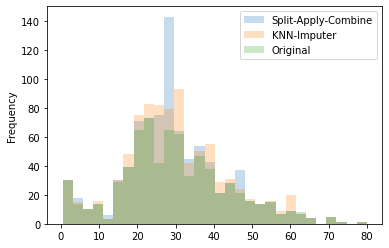

In [18]:
# let's show some very basic plotting to be sure the data looks about the same
# Which imputation did better? The PSlit-Apply-Combine, or  nearest Neighbor Imputer? 
bin_num = 30
df_imputed_sac.Age.plot(kind='hist', alpha=0.25, 
                        label="Split-Apply-Combine",
                        bins=bin_num)

df_imputed.Age.plot(kind='hist', alpha=0.25, 
                        label="KNN-Imputer",
                        bins=bin_num)

df.Age.plot(kind='hist', alpha=0.25, 
                        label="Original",
                        bins=bin_num)
plt.legend()
plt.show()

________________
**[End of Demo for Data Quality Lecture]**

**[Back to Slides]**

# Feature Discretization
This is an example of how to make a continuous feature and ordinal feature. Let's try to give some human intuition to a variable by grouping the data by age. 

**Question: Does age range influence survival rates?**

In [ ]:
# let's break up the age variable
df_imputed['age_range'] = pd.cut(df_imputed['Age'],[0,10,18,30, 65,1e6],
                                 labels=['child','teen','young adult','adult','senior']) # this creates a new variable
df_imputed.age_range.describe()

In [ ]:
# now lets group with the new variable
df_grouped = df_imputed.groupby(by=['Pclass','age_range'])
print ("Percentage of survivors in each group:")
print (df_grouped.Survived.sum() / df_grouped.Survived.count() *100)

__________
___________
# Visualization in Python with Pandas, Matplotlib, and Others

In [ ]:
# this python magics will allow plot to be embedded into the notebook
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

print('Matplotlib:', matplotlib. __version__)
# could also say "%matplotlib notebook" here to make things interactive

___________
## Visualizing the dataset

Pandas has plenty of plotting abilities built in. Let's take a look at a few of the different graphing capabilities of Pandas with only matplotlib. Afterward, we can make the visualizations more beautiful.

### Visualization Techniques: Distributions
- Histogram 
 - Usually shows the distribution of values of a single variable
 - Divide the values into bins and show a bar plot of the number of objects in each bin. 
- Kernel Density Estimation
 - Add up Gaussian underneath each point value
 - STD of gaussian is visually related to "number of bins" for a histogram
 
 **KDE Example:** 
 <img src="PDF_slides/kernels.gif" alt="TukeyBoxplot" width="600" height="600">
 
 ___
 
 
 #### Plot Type Two: Histogram and Kernel Density
 
 **Question: What were the ages of people on the Titanic?**

In [ ]:
# Start by just plotting what we previously grouped!
plt.style.use('ggplot')

fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
df_imputed.Age.plot.hist(bins=20)

plt.subplot(1,3,2)
df_imputed.Age.plot.kde(bw_method=0.2)

plt.subplot(1,3,3)
df_imputed.Age.plot.hist(bins=50)
df_imputed.Age.plot.kde(bw_method=0.05, secondary_y=True)

# remember that visualization is interpretted, it supports evidence.
# plt.ylim([0, 0.06])

plt.show()

### Two-Dimensional Distributions
- Estimate the joint distribution of the values of two attributes 
 - Example: petal width and petal length
  - What does this tell us? 
  
 **Question: How does age relate to the fare that was paid?**

In [ ]:
plt.hist2d(x=df_imputed.Age, y=df_imputed.Fare, bins=30)
plt.colorbar()
plt.xlabel("Age")
plt.ylabel("Fare")
plt.show()

The above plot is not all that meaningful. We can probably do better than visualizing the joint distribution using 2D histograms. Let's face it: 2D histrogram are bound to be sparse and not very descriptive. Instead, let's do something smarter.

## Feature Correlation Plot
 - First lets visualize the correlation between the different features.
 
  #### Plot Type Three: Heatmap (of correlation)

In [ ]:
# plot the correlation matrix 
vars_to_use = ['Survived', 'Age', 'Parch', 'SibSp', 'Pclass', 'Fare'] # pick vars
plt.pcolor(df_imputed[vars_to_use].corr()) # do the feature correlation plot

# fill in the indices
plt.yticks(np.arange(0.5, len(vars_to_use), 1), vars_to_use)
plt.xticks(np.arange(0.5, len(vars_to_use), 1), vars_to_use)
plt.colorbar()
plt.show()

### Grouped Count Plots
Used when you have multiple categorical or nominal variables that you want to show together in sub-groups. Grouping mean to display the counts of different subgroups on the dataset. For the titanic data, this can be quite telling of the dataset.

**Question: Does age, gender, or class have an effect on survival?**

 #### Plot Type Four: Grouped Bar Chart

In [ ]:
# first group the data
df_grouped = df_imputed.groupby(by=['Pclass','age_range'])

# tabulate survival rates of each group
survival_rate = df_grouped.Survived.sum() / df_grouped.Survived.count()

# show in a bar chart using builtin pandas API
ax = survival_rate.plot(kind='barh')
plt.title('Survival Percentages by Class and Age Range')
plt.show()

In [ ]:
# the cross tab operator provides an easy way to get these numbers
survival = pd.crosstab([df_imputed['Pclass'],
                        df_imputed['age_range']], # categories to cross tabulate
                       df_imputed.Survived.astype(bool)) # how to group
print(survival)

survival.plot(kind='bar', stacked=True)
plt.show()

In [ ]:
# plot overall cross tab with both groups
plt.figure(figsize=(15,3))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

pd.crosstab([df_imputed['Pclass']], # categories to cross tabulate
            df_imputed.Survived.astype(bool)).plot(kind='bar', stacked=True, ax=ax1) 

pd.crosstab([df_imputed['age_range']], # categories to cross tabulate
            df_imputed.Survived.astype(bool)).plot(kind='bar', stacked=True, ax=ax2) 

pd.crosstab([df_imputed['Sex']], # categories to cross tabulate
            df_imputed.Survived.astype(bool)).plot(kind='bar', stacked=True, ax=ax3) 

plt.show()

### Sub-group Distribution Plots
- Box Plots 
 - Invented by J. Tukey
 - Another way of displaying the distribution of data 
 - Following figure shows the basic part of a box plot:
 
<img src="data/TukeyPlot.png" alt="TukeyBoxplot" width="600" height="600">

 #### Plot Type Five: Box Plot

In [ ]:
ax = df_imputed.boxplot(column='Fare', by = 'Pclass') # group by class
plt.ylabel('Fare')
plt.title('')
# ax.set_yscale('log') # so that the boxplots are not squished

The problem with boxplots is that they might hide important aspects of the ditribution. For example, this plot shows data that all have the exact same boxplot.

<img src="https://i.redd.it/cad7mdrg9wez.gif" alt="TukeyBoxplot" width="600" >

# Simplifying Plotting with Seaborn


Using pandas and matplotlib is great until you need to redo or make more intricate plots. Let's see about one or two APIs that might simplify our lives. First, let's use Seaborn.
+ `import seaborn as sns` 

In seaborn, we have access to a number of different plotting tools. Let's take a look at:
 #### Plot Type Six:
- Box Plots
- Swarm Plots
- Violin Plots

In [ ]:
import seaborn as sns
# cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

print('Seaborn:', sns. __version__)
# now try plotting some of the previous plots, way more visually appealing!!

In [ ]:
# sns boxplot
plt.subplots(figsize=(20, 5))

plt.subplot(1,3,1)
sns.boxplot(x="Sex", y="Age", hue="Survived", data=df_imputed)
plt.title('Boxplot Example')

plt.subplot(1,3,2)
sns.violinplot(x="Sex", y="Age", hue="Survived", data=df_imputed)
plt.title('Violin Example')

plt.subplot(1,3,3)
sns.swarmplot(x="Sex", y="Age", hue="Survived", data=df_imputed)
plt.title('Swarm Example')

plt.show()

In [ ]:
# ASIDE: UGH so much repeated code, can we do "better"?
# this use slick python functionality as the cost of readability
plt.subplots(figsize=(20, 5))
args = {'x':"Sex", 'y':"Age", 'hue':"Survived", 'data':df_imputed}
for i, plot_func in enumerate([sns.boxplot, sns.violinplot, sns.swarmplot]):
    plt.subplot(1,3,i+1)
    plot_func(**args) # more compact, LESS readable
    
plt.show()

In [ ]:
sns.violinplot(x="Sex", y="Age", hue="Survived", data=df_imputed, 
               split=True, # split across violins
               inner="quart", # show innner stats like mena, IQR, 
               scale="count") # scale the size of the plot by the count within each group

plt.show()

________


### Self Test 2a.2
<img src="data/self_test_2a_2.png" alt="TukeyBoxplot" width="600" height="600">



____
### Matrix Plots
- Plot some data from a matrix
- This can be useful when objects are sorted well
- Typically, the attributes are normalized to prevent one attribute from dominating the plot
- Plots of similarity or distance matrices can also be useful for visualizing the relationships between objects
- Two versions:
 - Feature Based
 - Instance Based
 
 **Question: Which features are most similar to each other?**

In [ ]:
# the correlation plot is Feature based becasue we get
# a place in the plot for each feature
# in this plot we are asking, what features are most correlated? 
cmap = sns.set(style="darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df_imputed.corr(), cmap=cmap, annot=True)

# f.tight_layout()


____

**New Question: Which passengers are most similar to one another?**

In [ ]:
# but we could also be asking, what instances are most similar to each other?

# NOTE: Correlation here is defined as a distance metric by scipy 
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.correlation.html 
# it is defined as 1-CC, so '0' means highly correlated

from sklearn.metrics.pairwise import pairwise_distances

vars_to_use = [ 'Age', 'Pclass', 'Fare', 'SibSp','Parch'] # pick vars

xdata = pairwise_distances(df_imputed[vars_to_use].to_numpy(), # get numpy matrix
                           metric='correlation')

sns.heatmap(xdata, cmap=cmap, annot=False)
print('What is wrong with this plot?')

In [ ]:
# lets fix a few things
# first, the difference between each instance was large, 
#  impacted by the biggest variable, Fare

from sklearn.preprocessing import StandardScaler

# lets scale the data to be zero mean, unit variance
std = StandardScaler()

xdata = pairwise_distances(std.fit_transform(df_imputed[vars_to_use].to_numpy()), 
                           metric='correlation')
sns.heatmap(xdata, cmap=cmap, annot=False)
print('Is there still something wrong?')

In [ ]:
f, ax = plt.subplots(figsize=(8, 7))

# lets scale the data to be zero mean, unit variance
std = StandardScaler()
# and lets also sort the data
df_imputed_copy = df_imputed.copy().sort_values(by=['Pclass','Age'])

xdata = pairwise_distances(std.fit_transform(df_imputed_copy[vars_to_use].to_numpy()), 
                           metric='correlation')
sns.heatmap(xdata, cmap=cmap, annot=False)
print('Is there anything we can conclude?')

______
## Revisiting other Plots in Seaborn

In [ ]:
# can we make a better combined histogram and KDE?
sns.histplot(df_imputed.Age, kde=True)
plt.show()

In [ ]:
# lets make a pretty plot of the scatter matrix
df_imputed_jitter = df_imputed.copy()
df_imputed_jitter[['Parch','SibSp','Pclass']] += np.random.rand(len(df_imputed_jitter),3)/2 
sns.pairplot(df_imputed_jitter, hue="Survived", height=2,
            plot_kws=dict(s=20, alpha=0.15, linewidth=0))
plt.show()

# A Final Note on Plotting:
The best plots that you can make are probably ones that are completely custom to the task or question you are trying to solve/answer. These plots are also the most difficult to get correct because they take a great deal of iteration, time, and effort to get perfected. They also take some time to explain. There is a delicate balance between creating a new plot that answers exactly what you are asking (in the best way possible) and spending and inordinate amount of time on a new plot (when a standard plot might be a "pretty good" answer)

<img src="PDF_slides/Customplots.png" alt="TukeyBoxplot" width="600" height="600">


____
# Revisiting with Interactive Visuals: Plotly
- https://plot.ly/python/getting-started/

More updates to come to this section of the notebook. Plotly is a major step in the direction of using JavaScript and python together and I would argue it has a much better implementation than other packages. 

In [ ]:
# directly from the getting started example...
import plotly
print('Plotly:', plotly. __version__)

plotly.offline.init_notebook_mode() # run at the start of every notebook
plotly.offline.iplot({
    "data": [{
        "x": [1, 2, 3],
        "y": [4, 2, 5]
    }],
    "layout": {
        "title": "hello world"
    }
})

In [ ]:
from plotly.graph_objs import Scatter, Layout
from plotly.graph_objs.scatter import Marker
from plotly.graph_objs.layout import XAxis, YAxis
# let's manipulate the example to serve our purposes

# plotly allows us to create JS graph elements, like a scatter object
plotly.offline.iplot({
    'data':[
        Scatter(x=df_imputed.SibSp.values+np.random.rand(*df_imputed.SibSp.shape)/2,
                y=df_imputed.Age,
      
                text=df_imputed.Survived.values.astype(str),
                marker=Marker(size=df_imputed.Fare, sizemode='area', sizeref=1,),
                mode='markers')
            ],
    'layout': Layout(xaxis=XAxis(title='Sibling and Spouses'), 
                     yaxis=YAxis(title='Age'),
                     title='Age and Family Size (Marker Size==Fare)')
}, show_link=False)

Visualizing more than three attributes requires a good deal of thought. In the following graph, lets use interactivity to help bolster the analysis. We will create a graph with custom text overlays that help refine the passenger we are looking at. We will 
- color code whether they survived
- Scatter plot Age and Social class
- Code the number of siblings/spouses traveling with them through the size of the marker

In [ ]:
def get_text(df_row):
    return 'Age: %d<br>Gender: %s<br>Class: %d<br>Fare: %.2f<br>SibSpouse: %d<br>ParChildren: %d'%(df_row.Age,df_row.Sex,df_row.Pclass,df_row.Fare,df_row.SibSp,df_row.Parch)

df_imputed['text'] = df_imputed.apply(get_text,axis=1)
textstring = ['Perished','Survived', ]

plotly.offline.iplot({
    'data': [ # creates a list using a comprehension
        Scatter(x=df_imputed.Pclass[df_imputed.Survived==val].values+np.random.rand(*df_imputed.SibSp[df_imputed.Survived==val].shape)/2,
                y=df_imputed.Age[df_imputed.Survived==val],
                text=df_imputed.text[df_imputed.Survived==val].values.astype(str),
                marker=Marker(size=df_imputed[df_imputed.Survived==val].SibSp, sizemode='area', sizeref=0.01,),
                mode='markers',
                name=textstring[val]) for val in [0,1]
    ],
    'layout': Layout(xaxis=XAxis(title='Social Class'), 
                     yaxis=YAxis(title='Age'),
                     title='Age and Class Scatter Plot, Size = number of siblings and spouses'),
    
}, show_link=False)

Check more about using plotly here:
- https://plot.ly/python/ipython-notebook-tutorial/ 

**In this notebook you learned:**
- How to read in from a file using pandas
- How to manipulate data with basic operations in pandas
- How to group data in pandas 
- How to use Scikit-learn and pandas for imputation
- Some common visualizations in Pandas, Seaborn, and Plotly

Want some additional practice?
Try to create and use some Bokeh examples that are similar to the plots we created